In [13]:
import numpy as np
from copy import deepcopy
from pprint import pprint
import sys, os, time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm


sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')

from futils import extract_weights, data2percentile, jthreshold, permute_weights, get_cutoff, get_distance
from rnn_modeling_utils import solve_stochastic_euler
from modeling_analysis_utils import extract_top_J, load_simulation_parameters, plot_example_traces
from graph_utils import generate_snap_unweighted_graph
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

## ei analysis, modularity analysis, motif analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from modeling_analysis_utils import load_neurons
FISH_ID = 2
traces_full_filepath         = '../../data/f090518-%iZbrain_IDs.npz' % FISH_ID
mask_filepath                = '../../data/f090518-%iZbrain_IDs.npz' % FISH_ID

###
_, all_spatial_coords        = load_neurons(mask_filepath, region_name=['Telencephalon -', 
                                                                         'Mesencephalon -', 
                                                                         'Diencephalon -', 
                                                                         'Rhombencephalon -',], extend=True)
all_spatial_coords = np.asarray(all_spatial_coords, dtype='float32')

_, dthalamus_spatial_coords  = load_neurons(mask_filepath, region_name='Diencephalon - Dorsal Thalamus')
_, vthalamus_spatial_coords = load_neurons(mask_filepath, region_name='Diencephalon - Ventral Thalamus')

_, cerebellum_spatial_coords = load_neurons(mask_filepath, region_name='Rhombencephalon - Cerebellum')
_, hypothalamus_spatial_coords   = load_neurons(mask_filepath, region_name='Diencephalon - Intermediate Hypothalamus')
                                                                        
_, preoptic_spatial_coords = load_neurons(mask_filepath,region_name='Diencephalon - Preoptic Area')
_, tectum_spatial_coords   = load_neurons(mask_filepath, region_name='Mesencephalon - Tectum Stratum Periventriculare')



In [45]:
FISH_ID = 3
version = 1

def acquire_info(date, state, idx):
    J_filepath           = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/training-%s' % (FISH_ID, state, version, date)
    parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)

    f = np.load(J_filepath + '/full-%s-%i.npz' % (state,idx), allow_pickle=True)
    J = f['J']
    N = J.shape[0]
    f.close()

    simulation_kwargs = load_simulation_parameters(parameters_filepath)
    simulation_kwargs['J'] = J
    S = simulation_kwargs['S']

    Ytruth = simulation_kwargs['Ytruth']
    currents    = solve_stochastic_euler(**simulation_kwargs)
    activations = np.tanh(currents)
    Ymodel      = np.matmul(J, activations)


    simulation_kwargs['H'] = np.zeros_like(simulation_kwargs['H'], dtype='float32')
    currents_naked    = solve_stochastic_euler(**simulation_kwargs)
    activations_naked = np.tanh(currents_naked)
    Ymodel_naked     = np.matmul(J, activations_naked)
    
    return {'S': S, 'spatial': simulation_kwargs['spatial'], 'J': J, 'Ytruth': Ytruth, 'Ymodel': Ymodel, 'Ymodel naked': Ymodel_naked, 'currents': currents, 'currents naked': currents_naked}

# 2 381 270
# 3 646 285
# 5 362 83

baseline_data = acquire_info('3152020', 'baseline', 646)
presz_data    = acquire_info('3152020', 'presz', 285)

Jbaseline = baseline_data['J']
Jpresz    = presz_data['J']

In [6]:
np.savez('fish3-RNN-baseline-data.npz', traces=baseline_data['Ytruth'][:,:], S=baseline_data['S'], spatial=baseline_data['spatial'])
np.savez('fish3-RNN-presz-data.npz', traces=presz_data['Ytruth'][:,:], S=presz_data['S'], spatial=presz_data['spatial'])

In [65]:
from graph_utils import extract_motifs
   
th = 90
Jbaseline_th             = jthreshold(Jbaseline,th,above=True,pos=True,binarized=True)
baseline_sender_triplets = extract_motifs(Jbaseline_th.T, motif='send')
baseline_receiver_triplets = extract_motifs(Jbaseline_th.T, motif='receive')

Jpresz_th         = jthreshold(Jpresz, th, above=True, pos=True, binarized=True)
presz_sender_triplets = extract_motifs(Jpresz_th.T, motif='send')
presz_receiver_triplets = extract_motifs(Jpresz_th.T, motif='receive')



0 117107
5000 117107
10000 117107
15000 117107
20000 117107
25000 117107
30000 117107
35000 117107
40000 117107
45000 117107
50000 117107
55000 117107
60000 117107
65000 117107
70000 117107
75000 117107
80000 117107
85000 117107
90000 117107
95000 117107
100000 117107
105000 117107
110000 117107
115000 117107
0 117107
5000 117107
10000 117107
15000 117107
20000 117107
25000 117107
30000 117107
35000 117107
40000 117107
45000 117107
50000 117107
55000 117107
60000 117107
65000 117107
70000 117107
75000 117107
80000 117107
85000 117107
90000 117107
95000 117107
100000 117107
105000 117107
110000 117107
115000 117107
0 118139
5000 118139
10000 118139
15000 118139
20000 118139
25000 118139
30000 118139
35000 118139
40000 118139
45000 118139
50000 118139
55000 118139
60000 118139
65000 118139
70000 118139
75000 118139
80000 118139
85000 118139
90000 118139
95000 118139
100000 118139
105000 118139
110000 118139
115000 118139
0 118139
5000 118139
10000 118139
15000 118139
20000 118139
25000 1

In [40]:
from perturbation_simul_utils import multi_ablation, ablation_expr
from graph_utils import get_outgoing_degrees, extract_outgoing_hubs

## F2

#thalamus_idxs = [1905,1906,1914,1944,1945,1946,1947,1948,1949,1950,1953,1954,1968,1971,1982,2032,2035,2038,2039,2040,2041,2045,2048,2056,2064,2065,2069,2070,2144,2186,2187,2188,2189,2190,2191,2193,2195,2200,2201,2205,2215,2251,2252,2257,2262,2267,2293,2300,2303,3894,3943,3944,3952,4063,4066,4068,4072,4074,4075,4077,4078,4079,4080,4081,4084,4086,4090,4092,4098,4099,4100,4104,4106,4107,4108,4109,4110,4111,4113,4117,4118,4125,4127,4131,4133,4134,4135,4141,4144,4147,4148,4156,4163,4164,4171,4172,4178,4180,4181,4182,4183,4184,4185,4187,4188]
#telen_idxs    = [545,547,550,552,557,560,563,1342,1363,1364,1368,1372,1374,1376,1377,1380,1384,1385,1386,1389,1391,1397,1410,1415,1426,1427,1431,1436,1437,1439,1440,1448,1504,1518,1521,1528,1530,1533,1559,1561,1562,1563,1564,1574,1582,1585,1586,1590,1593,1594,1600,1602,1605,1606,1609,1615,1621,1623,1626,1627,1644,1649,1650,1654,1669,1674,1675,1676,1684,1685,1688,1714,1717,1718,1719,1720,1725,1740,1742,1744,1746,1748,1749,1760,1766,1769,1781,1782,1784,1798,1800,1806,1819,1821,1827,1828,1831,1838,1859,1867,1871,1877,1879,2089,2091,2093,2094,2096,2098,2113,2114,2115,2116,2118,2120,2132,2134,2138,2140,2142,2177,2178,2184,2227,2230,2232,2234,2236,2239,2247,2255,2256,2259,2260,2264,2265,2266,2269,2270,2281,2284,2346,2354,2371,2458,2460,2466,2484,2489,2523,2530,2538,2543,2546,2593,2600,2602,2603,2611,2617,2621,2626,2632,2639,2643,2658,2667,2676,2683,2685,2688,2691,2717,2725,2728,2767,2770,2785,2802,2809,2822,2834,2848,2861,2879,4093,4155]
#tectum_idxs   = [17,19,27,28,40,45,48,57,59,76,88,89,94,119,120,124,129,132,139,149,154,167,168,170,171,188,189,234,241,246,264,269,275,276,283,289,305,324,332,335,337,339,360,364,368,394,420,424,428,439,443,448,459,461,475,482,491,494,504,505,508,509,512,513,519,523,593,596,660,669,796,857,931,938,942,945,946,957,958,1020,1067,1076,1126,1143,1163,1185,1191,1193,1223,1229,1263,1264,1282,1309,1317,1330,1899,1998,2004,2317,2375,2391,2412,2452,2505,2888,2890,2903,2926,2938,2939,2949,2960,2961,2975,2976,2982,2983,2987,2992,3040,3056,3075,3077,3086,3093,3104,3108,3116,3125,3126,3161,3162,3171,3177,3181,3183,3184,3190,3197,3200,3203,3204,3207,3208,3210,3211,3212,3214,3218,3223,3224,3226,3234,3238,3239,3245,3247,3250,3253,3255,3267,3268,3274,3280,3284,3291,3321,3348,3349,3355,3357,3359,3378,3387,3391,3393,3401,3404,3411,3420,3428,3436,3437,3438,3455,3457,3461,3468,3483,3509,3533,3537,3556,3557,3560,3563,3564,3565,3569,3586,3589,3590,3592,3595,3604,3625,3627,3629,3632,3637,3638,3639,3640,3645,3649,3653,3665,3666,3671,3676,3677,3680,3681,3684,3685,3686,3690,3691,3692,3694,3707,3711,3718,3724,3725,3729,3732,3736,3738,3751,3755,3758,3760,3767,3771,3777,3779,3792,3808,3817,3818,3820,3838,3843,3844,3849,3865,3979,4228,4255,4259,4289,4292,4332,4338,4356,4369,4478,4482,4505,4509]

# F5

thalamus_idxs = [2001,2033,2036,2080,2081,2082,2090,2100,2102,2105,2106,2107,2113,2124,2126,2127,2131,2132,2133,2136,2138,2139,2149,2179,2183,2185,2186,2187,2188,2192,2193,2195,2196,2197,2198,2202,2203,2204,2207,2209,2211,2212,2213,2214,2215,2216,2219,2221,2223,2232,2233,2234,2237,2238,2239,2244,2451,2454,2459,2471,2472,2499,2512,2710,4367,4373,4374,4388,4393,4396,4397,4402,4403,4406,4408,4411,4413,4414,4415,4417,4421,4422,4423,4447,4449,4456,4463,4471,4474,4477,4479,4488,4489,4491,4492,4493,4504,4507,4508]
tectum_idxs   = [96,189,190,196,230,232,233,235,246,258,260,265,274,298,343,366,370,380,381,382,398,404,416,419,420,421,423,427,439,658,662,664,840,844,845,851,900,1065,1070,1078,1099,1111,1115,1120,1189,1196,1204,1227,1229,1232,1234,1238,1239,1242,1258,1259,1270,1935,1978,2245,2247,2250,2251,2326,2333,2337,2339,2340,2372,2374,2384,2428,2443,2977,2986,3016,3017,3019,3020,3021,3024,3033,3039,3041,3043,3044,3045,3051,3052,3053,3055,3067,3068,3069,3077,3081,3082,3099,3101,3102,3106,3111,3113,3114,3123,3136,3139,3146,3147,3152,3155,3162,3168,3170,3171,3172,3173,3175,3176,3177,3181,3187,3188,3192,3196,3197,3199,3201,3206,3216,3225,3226,3229,3231,3232,3235,3240,3245,3250,3251,3253,3254,3255,3261,3262,3270,3273,3280,3281,3290,3295,3299,3301,3302,3305,3311,3320,3324,3325,3326,3332,3349,3353,3354,3365,3368,3370,3378,3393,3396,3402,3437,3438,3439,3440,3452,3487,3568,3609,3612,3613,3645,3650,3658,3660,3661,3663,3667,3668,3669,3670,3681,3686,3690,3693,3694,3697,3700,3702,3704,3708,3713,3718,3728,3729,3736,3737,3743,3748,3749,3751,3755,3759,3763,3765,3768,3769,3771,3777,3781,3783,3786,3787,3792,3797,3801,3803,3805,3807,3812,3816,3818,3833,3842,3845,3849,3851,3852,3854,3856,3859,3860,3864,3865,3882,3887,3891,3902,3903,3904,3907,3908,3928,3932,3935,3944,3945,3949,3951,3969,3970,3974,3997,4001,4003,4008,4011,4019,4022,4029,4035,4037,4039,4048,4049,4059,4060,4064,4075,4076,4090,4092,4093,4170,4172,4221,4271,4429,4576,4587,4612,4614,4629,4655,4658,4676,4698,4730,4745,4770]
telen_idxs    = [511,523,1439,1440,1443,1445,1475,1482,1487,1491,1492,1493,1496,1497,1500,1505,1507,1510,1514,1515,1520,1523,1538,1544,1551,1554,1555,1558,1565,1567,1573,1578,1580,1590,1608,1619,1623,1626,1631,1650,1652,1658,1664,1679,1684,1686,1694,1701,1702,1706,1710,1715,1719,1721,1722,1735,1746,1754,1755,1756,1758,1759,1760,1763,1771,1785,1786,1789,1791,1794,1800,1802,1806,1808,1831,1835,1842,1846,1850,1852,1862,1864,1867,1870,1882,1886,1890,1899,1900,1908,2006,2007,2043,2056,2069,2072,2073,2074,2076,2104,2141,2142,2153,2165,2166,2171,2172,2173,2174,2363,2388,2390,2402,2518,2523,2529,2531,2532,2537,2538,2540,2543,2544,2550,2566,2568,2580,2586,2593,2596,2601,2609,2615,2616,2620,2622,2624,2632,2639,2642,2644,2645,2646,2648,2651,2663,2666,2667,2671,2675,2680,2681,2688,2726,2730,2748,2755,2760,2764,2767,2778,2786,2800,2804,2826,2831,2832,2835,2851,2854,2860,2866,2867,2869,2875,2879,2882,2889,2891,2924,4364,4370,4428,4497] 

telen = telen_idxs
tectum = tectum_idxs
thalamus = thalamus_idxs

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


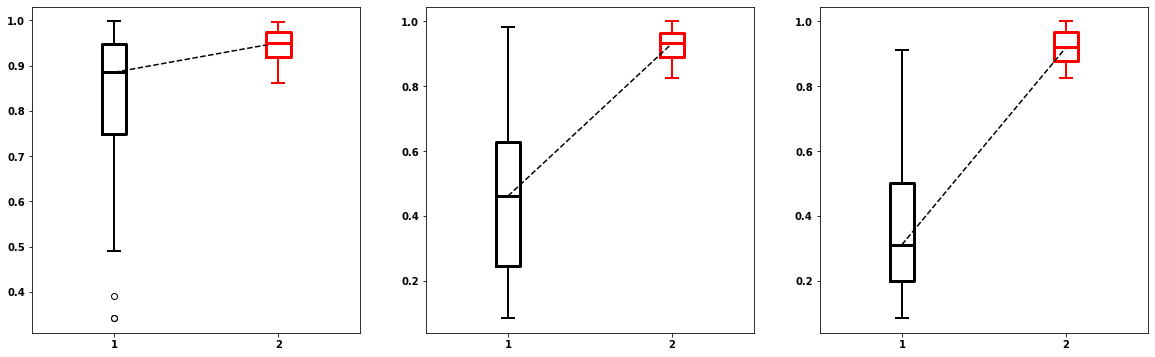

In [4]:
###

presz_outgoing = get_outgoing_degrees(Jpresz, 90)
presz_percentiles     = data2percentile(presz_outgoing)

baseline_outgoing = get_outgoing_degrees(Jbaseline, 90)
baseline_percentiles  = data2percentile(baseline_outgoing)

# plt.figure()
# plt.hist([np.divide(baseline_outgoing,float(Jpresz.shape[0]-1)), np.divide(presz_outgoing, float(Jpresz.shape[0]-1))], color=['k', 'r'], rwidth=0.65, density=True)
# plt.show()


thalamus_presz_percentiles = presz_percentiles[thalamus]
thalamus_baseline_percentiles = baseline_percentiles[thalamus]

# telen_presz_percentiles = presz_percentiles[telen]
# telen_baseline_percentiles = baseline_percentiles[telen]

# tectum_presz_percentiles = presz_percentiles[tectum]
# tectum_baseline_percentiles = baseline_percentiles[tectum]


# plt.figure()
# plt.boxplot([telen_baseline_percentiles, telen_presz_percentiles], positions=[0,1])
# plt.title('telen')
# plt.show()


# plt.figure()
# plt.boxplot([tectum_baseline_percentiles, tectum_presz_percentiles], positions=[0,1])
# plt.show()


# plt.figure()
# bplot = plt.boxplot([thalamus_baseline_percentiles, thalamus_presz_percentiles])
# plt.plot([1,2], [np.median(thalamus_baseline_percentiles), np.median(thalamus_presz_percentiles)], color='k', linestyle='--')

# colors = ['k', 'r']
# for patch, color in zip(bplot['boxes'], colors):
#     patch.set_color(color)
#     patch.set_linewidth(3)
# for patch, color in zip(bplot['medians'], colors):
#     patch.set_color(color)
#     patch.set_linewidth(3)
    
# colors = ['k', 'k', 'r', 'r']
# for patch, color in zip(bplot['whiskers'], colors):
#     patch.set_color(color)
#     patch.set_linewidth(2)
    
# for patch, color in zip(bplot['caps'], colors):
#     patch.set_color(color)
#     patch.set_linewidth(2)


######

presz_percentiles     = data2percentile(get_outgoing_degrees(Jpresz.T, 90))
baseline_percentiles  = data2percentile(get_outgoing_degrees(Jbaseline.T, 90))

# thalamus_presz_percentiles = presz_percentiles[thalamus]
# thalamus_baseline_percentiles = baseline_percentiles[thalamus]

telen_presz_percentiles = presz_percentiles[telen]
telen_baseline_percentiles = baseline_percentiles[telen]

tectum_presz_percentiles = presz_percentiles[tectum]
tectum_baseline_percentiles = baseline_percentiles[tectum]


fig, ax = plt.subplots(1,3,figsize=(20,6)) 
bplot = ax[0].boxplot([thalamus_baseline_percentiles, thalamus_presz_percentiles])
ax[0].plot([1,2], [np.median(thalamus_baseline_percentiles), np.median(thalamus_presz_percentiles)], color='k', linestyle='--')
colors = ['k', 'r']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)


bplot = ax[1].boxplot([telen_baseline_percentiles, telen_presz_percentiles])
ax[1].plot([1,2], [np.median(telen_baseline_percentiles), np.median(telen_presz_percentiles)], color='k', linestyle='--')

colors = ['k', 'r']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)

bplot = ax[2].boxplot([tectum_baseline_percentiles, tectum_presz_percentiles])
ax[2].plot([1,2], [np.median(tectum_baseline_percentiles), np.median(tectum_presz_percentiles)], color='k', linestyle='--')

colors = ['k', 'r']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)

# plt.figure()
# plt.boxplot([thalamus_baseline_percentiles, thalamus_presz_percentiles], positions=[0,1])
# plt.show()



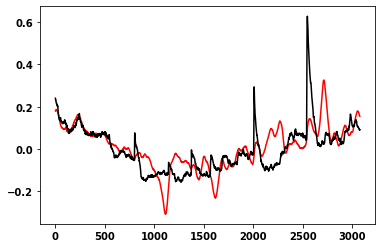

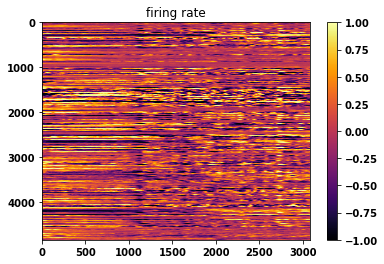

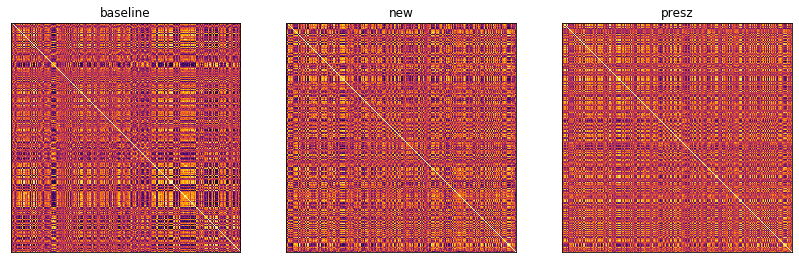

In [35]:
from perturbation_simul_utils import ablation_expr, plot_diagnostics

# np.arange(Jpresz.shape[0])

random_idxs = set(np.arange(Jpresz.shape[0])) - set(thalamus_idxs)
random_idxs = random_idxs - set(telen_idxs)
random_idxs = random_idxs - set(tectum_idxs)
random_idxs = np.asarray(list(random_idxs))

for i in range(1):
    kwargs = {'idxs': random_idxs, 'N': 15,
              'parameters_filepath': '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f5/presz/v1/additional-info-3152020.npz'}
    Y, currents, _ = ablation_expr(Jpresz, **kwargs)
    
    plt.figure()
    plt.plot(Y.mean(axis=0), color='r')
    plt.plot(presz_data['Ytruth'].mean(axis=0), color='k')
    plt.show()
    
    plt.figure()
    plt.imshow(np.tanh(currents), cmap='inferno', vmin=-1., vmax=1., aspect='auto')
    plt.colorbar()
    plt.title('firing rate')
    plt.show()
    
    plot_diagnostics(Y, baseline_data['Ytruth'], presz_data['Ytruth'])

    #np.savez('../data/fish-perturbation/f5/thalamus/fish-5-ablation-thalamus-2.npz', traces=Y[:,::2])

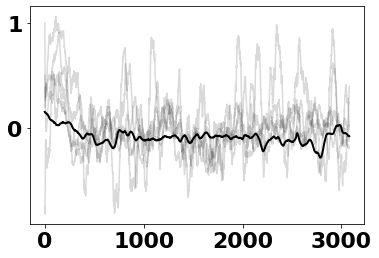

In [199]:
plt.figure()
plt.plot(Y[:5,:].T, color='k', alpha=0.15)
plt.plot(Y.mean(axis=0), color='k', linewidth=2)
plt.show()

th - random 0.01297622874197089
telen - random 0.4460080568006189
tectum - random 0.1428406693899846
th - tectum 0.013679919491043064
th - telen 0.0009803655639339436


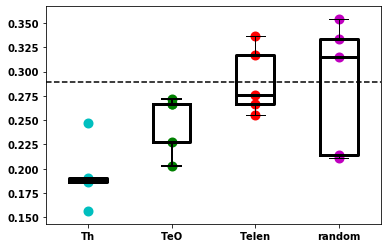

In [22]:
#f5
from scipy.stats import ranksums
from scipy.stats import ttest_ind

random = [0.354, 0.315, 0.214, 0.211, 0.334]
telen  = [0.337, 0.276, 0.317, 0.267, 0.255]
tectum = [0.267, 0.228, 0.267, 0.203, 0.272 ]
thalamus = [0.156, 0.186, 0.187, 0.190, 0.247]


plt.figure()
bplot = plt.boxplot([thalamus, tectum, telen, random], positions=[0,1,2,3], showfliers=False)
plt.xticks([0, 1, 2, 3], ['Th', 'TeO', 'Telen', 'random'])
plt.scatter([0 for _ in range(len(thalamus))], thalamus, color='c', linewidth=4)
plt.scatter([1 for _ in range(len(tectum))], tectum, color='g', linewidth=4)
plt.scatter([2 for _ in range(len(telen))], telen, color='r', linewidth=4)
plt.scatter([3 for _ in range(len(random))], random, color='m', linewidth=4)
plt.hlines(0.289, -0.5, 3.5, color='k', linestyle='--')


for patch, color in zip(bplot['boxes'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)





_, p = ttest_ind(random, thalamus)
print('th - random', p/2.)

_, p = ttest_ind(random, telen)
print('telen - random', p/2.)

_, p = ttest_ind(random, tectum)
print('tectum - random', p/2.)

_, p = ttest_ind(thalamus, tectum)
print('th - tectum', p/2.)

_, p = ttest_ind(thalamus, telen)
print('th - telen', p/2.)

In [66]:
from perturbation_simul_utils import multi_edge_swap_expr, edge_swap_expr
from graph_utils import filter_triplets, get_contagious_edges, get_bifan_edges

def get_motif_edges(triplets, idxsA, idxsB, idxsC=None):
    filtered = filter_triplets(triplets, idxsA, idxsB, idxsC)
    contagious_edges = get_contagious_edges(filtered)
    bifan_edges = get_bifan_edges(filtered)
    return contagious_edges, bifan_edges


baseline_th_telen_contagious_edges, baseline_th_telen_bifan_edges = get_motif_edges(baseline_sender_triplets, thalamus_idxs, telen_idxs)
presz_th_telen_contagious_edges, presz_th_telen_bifan_edges = get_motif_edges(presz_sender_triplets, thalamus_idxs, telen_idxs)

print('thalamus->telen contagious edges: %d, %d' % (len(baseline_th_telen_contagious_edges), len(presz_th_telen_contagious_edges)))
print('thalamus->telen bifan edges: %d, %d' % (len(baseline_th_telen_bifan_edges), len(presz_th_telen_bifan_edges)))

baseline_th_tect_contagious_edges, baseline_th_tect_bifan_edges = get_motif_edges(baseline_sender_triplets, thalamus_idxs, tectum_idxs)
presz_th_tect_contagious_edges, presz_th_tect_bifan_edges = get_motif_edges(presz_sender_triplets, thalamus_idxs, tectum_idxs)

print('thalamus->tectum contagious edges: %d, %d' % (len(baseline_th_tect_contagious_edges), len(presz_th_tect_contagious_edges)))
print('thalamus->tectum bifan edges: %d, %d' % (len(baseline_th_tect_bifan_edges), len(presz_th_tect_bifan_edges)))

baseline_th_cross_contagious_edges, baseline_th_cross_bifan_edges = get_motif_edges(baseline_sender_triplets, thalamus_idxs, telen_idxs, tectum_idxs)
presz_th_cross_contagious_edges, presz_th_cross_bifan_edges = get_motif_edges(presz_sender_triplets, thalamus_idxs, telen_idxs, tectum_idxs)

print('thalamus->telen+tec contagious edges: %d, %d' % (len(baseline_th_cross_contagious_edges), len(presz_th_cross_contagious_edges)))
print('thalamus->telen+tec bifan edges: %d, %d' % (len(baseline_th_cross_bifan_edges), len(presz_th_cross_bifan_edges)))

presz_triplet_edges = presz_th_telen_contagious_edges + presz_th_tect_contagious_edges + presz_th_cross_contagious_edges
presz_bifan_edges   = presz_th_telen_bifan_edges + presz_th_tect_bifan_edges + presz_th_cross_bifan_edges



thalamus->telen contagious edges: 201, 773
thalamus->telen bifan edges: 7, 46
thalamus->tectum contagious edges: 134, 1033
thalamus->tectum bifan edges: 4, 41
thalamus->telen+tec contagious edges: 337, 1801
thalamus->telen+tec bifan edges: 0, 38


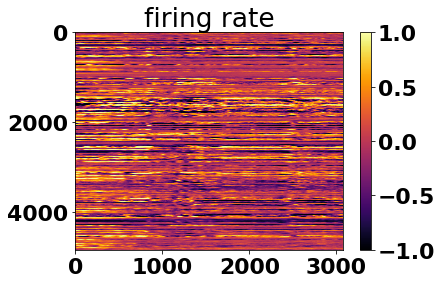

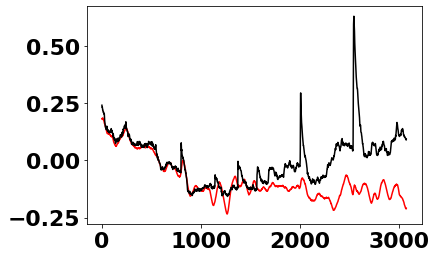

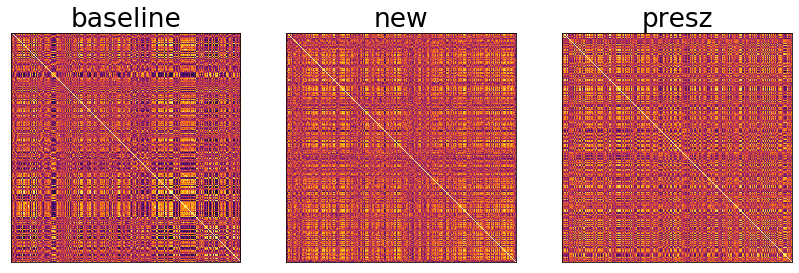

In [366]:
# bifan, triplets, random
kwargs = {'expr_type': 'random', 'nedges': 250, 'tover': 90, 'tunder': 10, 'swap': False,
          'bifan_edges': presz_bifan_edges, 'triplet_edges': presz_triplet_edges, 
          'parameters_filepath': '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f5/presz/v1/additional-info-3152020.npz'}

#def edge_swap_expr(J, **kwargs):
for i in range(0,1):
    Y, currents, _, _ = edge_swap_expr(Jpresz, **kwargs)
    
    plt.figure()
    plt.imshow(np.tanh(currents), cmap='inferno', vmin=-1., vmax=1., aspect='auto')
    plt.colorbar()
    plt.title('firing rate')
    plt.show()
    
    plt.figure()
    plt.plot(Y.mean(axis=0), color='r')
    plt.plot(presz_data['Ytruth'].mean(axis=0), color='k')
    plt.show()
    
    plot_diagnostics(Y, baseline_data['Ytruth'], presz_data['Ytruth'])

    
    #np.savez('../data/fish-perturbation/f5/edge-swap/bifan/fish-5-bifanswap-%d.npz' % i, traces=Y[:,::2])





bifan - random 0.025315018831122447
triplet - random 0.05916098196646723
triplet - bifan 0.00276248311639377


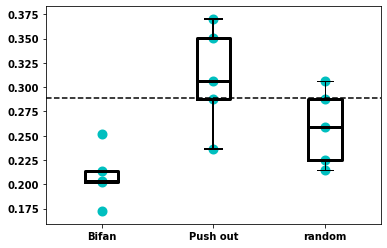

In [25]:
#f5
from scipy.stats import ranksums
from scipy.stats import ttest_ind

random = [0.215, 0.306, 0.288, 0.259, 0.225]
triplet  = [0.288, 0.370, 0.306, 0.351, 0.236]
bifan = [0.214, 0.202, 0.172, 0.252, 0.203]


plt.figure()
bplot = plt.boxplot([bifan, triplet, random], positions=[0,1,2], showfliers=False)
plt.xticks([0, 1, 2], ['Bifan', 'Push out', 'random'])
plt.scatter([0 for _ in range(len(bifan))], bifan, color='c', linewidth=4)
plt.scatter([1 for _ in range(len(triplet))], triplet, color='c', linewidth=4)
plt.scatter([2 for _ in range(len(random))], random, color='c', linewidth=4)
plt.hlines(0.289, -0.5, 2.5, color='k', linestyle='--')

for patch, color in zip(bplot['boxes'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)


_, p = ttest_ind(random, bifan)
print('bifan - random', p/2.)

_, p = ttest_ind(random, triplet)
print('triplet - random', p/2.)

_, p = ttest_ind(triplet, bifan)
print('triplet - bifan', p/2.)


0.56829655 0.38426837


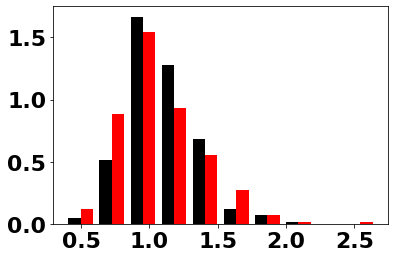

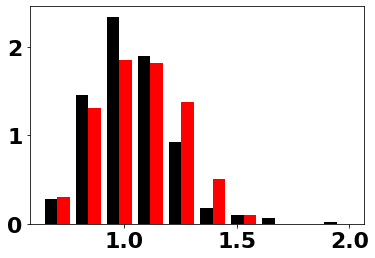

In [46]:
from graph_utils import get_outgoing_degrees
from futils import data2percentile, get_ei


def get_top_outgoing(J, percentile):
    outgoing = get_outgoing_degrees(J, percentile)
    outgoing_percentile = data2percentile(outgoing)
    return np.where( outgoing_percentile > 0.90)[0]
def get_top_incoming(J, percentile):
    incoming = get_outgoing_degrees(J.T, percentile)
    incoming_percentile = data2percentile(incoming)
    return np.where( incoming_percentile > 0.90)[0]
    

control_outgoing_top = get_top_outgoing(Jbaseline, 90)
control_incoming_top = get_top_incoming(Jpresz, 90)

sz_outgoing_top      = get_top_outgoing(Jbaseline, 90)
sz_incoming_top      = get_top_incoming(Jpresz, 90)

control_otop_pre_ei  = np.asarray([get_ei(Jbaseline[:,idx]) for idx in control_outgoing_top])
control_itop_post_ei = np.asarray([get_ei(Jbaseline[idx,:]) for idx in control_incoming_top])

sz_otop_pre_ei  = np.asarray([get_ei(Jpresz[:,idx]) for idx in sz_outgoing_top])
sz_itop_post_ei = np.asarray([get_ei(Jpresz[idx,:]) for idx in sz_incoming_top])

control_otop_pre_exc = control_outgoing_top[np.where(control_otop_pre_ei > 1.0)[0]]
control_itop_post_exc = control_incoming_top[np.where(control_itop_post_ei > 1.0)[0]]

sz_otop_pre_exc      = sz_outgoing_top[np.where(sz_otop_pre_ei > 1.0)[0]]
sz_itop_post_exc     = sz_incoming_top[np.where(sz_itop_post_ei > 1.0)[0]]

print(control_otop_pre_ei.min(), sz_otop_pre_ei.min())

plt.figure()
plt.hist([control_otop_pre_ei, sz_otop_pre_ei], color=['k', 'r'], density=True)
plt.show()

plt.figure()
plt.hist([control_itop_post_ei, sz_itop_post_ei], color=['k', 'r'], density=True)
plt.show()


[(500, 502)]
distance: 1.413


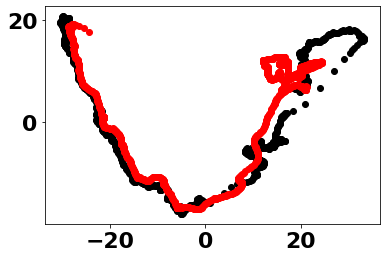

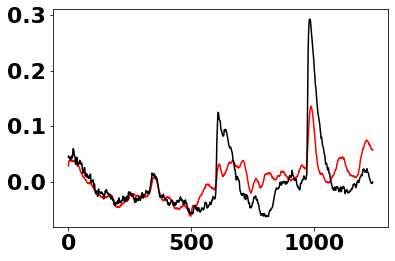

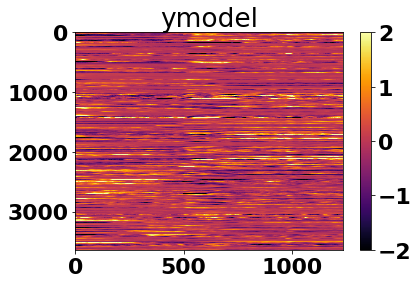

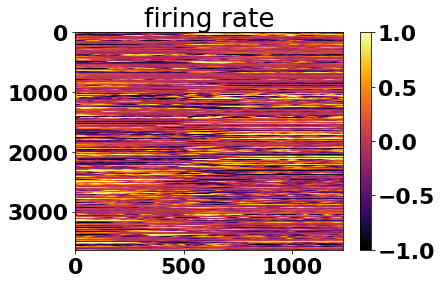

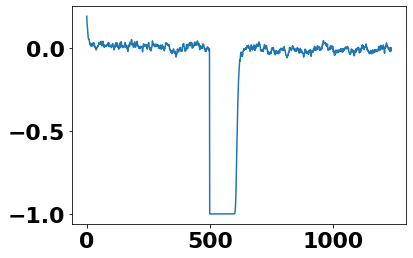

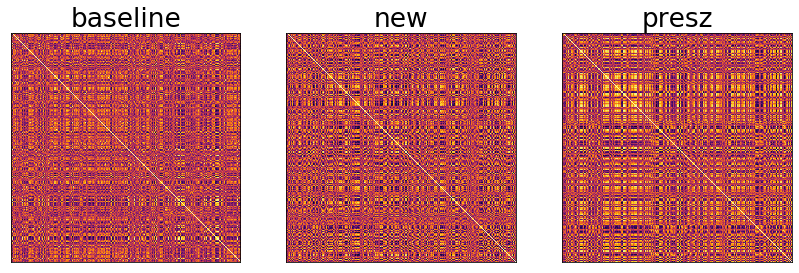

In [56]:
from perturbation_simul_utils import perturbation_expr, plot_diagnostics
from sklearn.decomposition import PCA
from copy import deepcopy


data = presz_data
J    = Jpresz
idxs = sz_outgoing_top
idxs   = [idxs[np.random.randint(len(idxs))] for i in range(1)]

perturbation_params = {}
perturbation_params['nids'] = idxs
perturbation_params['ton']  = [500]
perturbation_params['toff'] = [502]
perturbation_params['direction'] = ['down']
print(list(zip(perturbation_params['ton'], perturbation_params['toff'])))

kwargs = {'perturbation': perturbation_params,
          'parameters_filepath': '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f3/presz/v1/additional-info-3152020.npz'}
Ymodel, currents = perturbation_expr(J, **kwargs)
distance = get_distance(data['Ytruth'].mean(axis=0), Ymodel.mean(axis=0))
print('distance: %0.3f' % distance)

pca = PCA(n_components=2)
Yp_transformed = pca.fit_transform(data['Ytruth'].T).T
Ym_transformed = pca.transform(Ymodel.T).T

plt.figure()
plt.scatter(*Yp_transformed, color='k')
plt.scatter(*Ym_transformed, color='r')
plt.show()

N = len(perturbation_params['nids'])
non_nids = list(set(np.arange(data['Ytruth'].shape[0])) - set(idxs))
new_currents     = deepcopy(currents)
new_currents[:N,:] = currents[idxs,:]
new_currents[N:,:] = currents[non_nids,:]

plt.figure()
plt.plot(Ymodel.mean(axis=0), color='r')
plt.plot(data['Ytruth'].mean(axis=0), color='k')
plt.show()

plt.figure()
plt.imshow(Ymodel, cmap='inferno', aspect='auto', vmin=-2., vmax=2.)
plt.title('ymodel')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.tanh(new_currents), cmap='inferno', vmin=-1., vmax=1., aspect='auto')
plt.colorbar()
plt.title('firing rate')
plt.show()

plt.figure()
plt.plot(np.tanh(currents)[idxs,:].T)
plt.show()

plot_diagnostics(Ymodel, baseline_data['Ytruth'], presz_data['Ytruth'])


In [163]:
from perturbation_simul_utils import perturbation_expr, plot_diagnostics
from copy import deepcopy

distances = []
for (iidx, idxs) in enumerate([thalamus_idxs, telen_idxs, tectum_idxs]):
    distances.append([])
    for idx in idxs:
        perturbation_params = {}
        perturbation_params['nids'] = [idx]
        perturbation_params['ton']  = np.linspace(60, 1000, 2)
        perturbation_params['toff'] = np.add(perturbation_params['ton'], 2)
        perturbation_params['direction'] = ['down' for _ in range(len(perturbation_params['ton']))]
        kwargs = {'perturbation': perturbation_params,
                  'parameters_filepath': '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f5/presz/v1/additional-info-3152020.npz'}
        Ymodel, currents = perturbation_expr(Jpresz, **kwargs)
        current_distance = get_distance(presz_data['Ytruth'].mean(axis=0), Ymodel.mean(axis=0), norm=False)
        distances[iidx].append(current_distance)
        print('%d:%d. distance: %0.3f' % (iidx, idx, current_distance) )

    


0:4408. distance: 7.186
0:2105. distance: 3.724
0:2102. distance: 5.824
0:2204. distance: 7.971
0:2198. distance: 7.616
0:4396. distance: 7.217
0:2211. distance: 7.354
0:2459. distance: 7.824
0:2124. distance: 2.470
0:2207. distance: 5.187
0:4393. distance: 4.086
0:2233. distance: 4.432
0:2213. distance: 8.475
0:4491. distance: 3.345
0:4493. distance: 4.163
0:2185. distance: 4.509
0:2216. distance: 7.654
0:4403. distance: 2.468
0:2001. distance: 2.943
0:2186. distance: 5.355
0:2471. distance: 7.503
0:2113. distance: 4.035
0:2197. distance: 8.051
0:2209. distance: 7.437
0:4417. distance: 7.444
0:4477. distance: 1.837
0:2219. distance: 7.541
0:4397. distance: 6.031
0:2183. distance: 5.676
0:4463. distance: 7.331
0:4402. distance: 5.548
0:4488. distance: 3.541
0:2131. distance: 7.432
0:4423. distance: 2.007
0:4414. distance: 7.695
0:4492. distance: 7.379
0:4489. distance: 2.980
0:2195. distance: 7.982
0:2132. distance: 5.198
0:2512. distance: 7.654
0:4413. distance: 7.217
0:2080. distance

2:2250. distance: 1.973
2:2251. distance: 1.559
2:2326. distance: 1.363
2:2333. distance: 2.343
2:2337. distance: 3.494
2:2339. distance: 1.338
2:2340. distance: 3.083
2:2372. distance: 1.639
2:2374. distance: 2.695
2:2384. distance: 1.433
2:2428. distance: 1.433
2:2443. distance: 2.709
2:2977. distance: 1.367
2:2986. distance: 1.344
2:3016. distance: 1.399
2:3017. distance: 3.763
2:3019. distance: 1.747
2:3020. distance: 1.397
2:3021. distance: 1.686
2:3024. distance: 2.669
2:3033. distance: 3.449
2:3039. distance: 1.507
2:3041. distance: 1.434
2:3043. distance: 3.076
2:3044. distance: 1.532
2:3045. distance: 2.387
2:3051. distance: 1.465
2:3052. distance: 1.635
2:3053. distance: 1.687
2:3055. distance: 1.504
2:3067. distance: 1.417
2:3068. distance: 2.509
2:3069. distance: 2.246
2:3077. distance: 3.011
2:3081. distance: 1.394
2:3082. distance: 1.459
2:3099. distance: 1.897
2:3101. distance: 1.343
2:3102. distance: 1.704
2:3106. distance: 2.819
2:3111. distance: 4.186
2:3113. distance

In [441]:
time_distances = {}
for time in range(presz_data['Ytruth'].shape[1]-100):
    perturbation_params = {}
    perturbation_params['nids'] = idxs
    perturbation_params['ton']  = [time]
    perturbation_params['toff'] = [time+2]
    perturbation_params['direction'] = ['down']
    kwargs = {'perturbation': perturbation_params,
              'parameters_filepath': '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f5/presz/v1/additional-info-3152020.npz'}
    Ymodel, currents = perturbation_expr(Jpresz, **kwargs)
    current_distance = get_distance(presz_data['Ytruth'].mean(axis=0)[time:], Ymodel.mean(axis=0)[time:], norm=False)
    time_distances[time] = current_distance
    print('%d:%d' % (time, presz_data['Ytruth'].shape[1]))

[2221]
0:3079
1:3079
2:3079
3:3079
4:3079
5:3079
6:3079
7:3079
8:3079
9:3079
10:3079
11:3079
12:3079
13:3079
14:3079
15:3079
16:3079
17:3079
18:3079
19:3079
20:3079
21:3079
22:3079
23:3079
24:3079
25:3079
26:3079
27:3079
28:3079
29:3079
30:3079
31:3079
32:3079
33:3079
34:3079
35:3079
36:3079
37:3079
38:3079
39:3079
40:3079
41:3079
42:3079
43:3079
44:3079
45:3079
46:3079
47:3079
48:3079
49:3079
50:3079
51:3079
52:3079
53:3079
54:3079
55:3079
56:3079
57:3079
58:3079
59:3079
60:3079
61:3079
62:3079
63:3079
64:3079
65:3079
66:3079
67:3079
68:3079
69:3079
70:3079
71:3079
72:3079
73:3079
74:3079
75:3079
76:3079
77:3079
78:3079
79:3079
80:3079
81:3079
82:3079
83:3079
84:3079
85:3079
86:3079
87:3079
88:3079
89:3079
90:3079
91:3079
92:3079
93:3079
94:3079
95:3079
96:3079
97:3079
98:3079
99:3079
100:3079
101:3079
102:3079
103:3079
104:3079
105:3079
106:3079
107:3079
108:3079
109:3079
110:3079
111:3079
112:3079
113:3079
114:3079
115:3079
116:3079
117:3079
118:3079
119:3079
120:3079
121:3079
122:3

922:3079
923:3079
924:3079
925:3079
926:3079
927:3079
928:3079
929:3079
930:3079
931:3079
932:3079
933:3079
934:3079
935:3079
936:3079
937:3079
938:3079
939:3079
940:3079
941:3079
942:3079
943:3079
944:3079
945:3079
946:3079
947:3079
948:3079
949:3079
950:3079
951:3079
952:3079
953:3079
954:3079
955:3079
956:3079
957:3079
958:3079
959:3079
960:3079
961:3079
962:3079
963:3079
964:3079
965:3079
966:3079
967:3079
968:3079
969:3079
970:3079
971:3079
972:3079
973:3079
974:3079
975:3079
976:3079
977:3079
978:3079
979:3079
980:3079
981:3079
982:3079
983:3079
984:3079
985:3079
986:3079
987:3079
988:3079
989:3079
990:3079
991:3079
992:3079
993:3079
994:3079
995:3079
996:3079
997:3079
998:3079
999:3079
1000:3079
1001:3079
1002:3079
1003:3079
1004:3079
1005:3079
1006:3079
1007:3079
1008:3079
1009:3079
1010:3079
1011:3079
1012:3079
1013:3079
1014:3079
1015:3079
1016:3079
1017:3079
1018:3079
1019:3079
1020:3079
1021:3079
1022:3079
1023:3079
1024:3079
1025:3079
1026:3079
1027:3079
1028:3079
1029:307

1750:3079
1751:3079
1752:3079
1753:3079
1754:3079
1755:3079
1756:3079
1757:3079
1758:3079
1759:3079
1760:3079
1761:3079
1762:3079
1763:3079
1764:3079
1765:3079
1766:3079
1767:3079
1768:3079
1769:3079
1770:3079
1771:3079
1772:3079
1773:3079
1774:3079
1775:3079
1776:3079
1777:3079
1778:3079
1779:3079
1780:3079
1781:3079
1782:3079
1783:3079
1784:3079
1785:3079
1786:3079
1787:3079
1788:3079
1789:3079
1790:3079
1791:3079
1792:3079
1793:3079
1794:3079
1795:3079
1796:3079
1797:3079
1798:3079
1799:3079
1800:3079
1801:3079
1802:3079
1803:3079
1804:3079
1805:3079
1806:3079
1807:3079
1808:3079
1809:3079
1810:3079
1811:3079
1812:3079
1813:3079
1814:3079
1815:3079
1816:3079
1817:3079
1818:3079
1819:3079
1820:3079
1821:3079
1822:3079
1823:3079
1824:3079
1825:3079
1826:3079
1827:3079
1828:3079
1829:3079
1830:3079
1831:3079
1832:3079
1833:3079
1834:3079
1835:3079
1836:3079
1837:3079
1838:3079
1839:3079
1840:3079
1841:3079
1842:3079
1843:3079
1844:3079
1845:3079
1846:3079
1847:3079
1848:3079
1849:3079


2570:3079
2571:3079
2572:3079
2573:3079
2574:3079
2575:3079
2576:3079
2577:3079
2578:3079
2579:3079
2580:3079
2581:3079
2582:3079
2583:3079
2584:3079
2585:3079
2586:3079
2587:3079
2588:3079
2589:3079
2590:3079
2591:3079
2592:3079
2593:3079
2594:3079
2595:3079
2596:3079
2597:3079
2598:3079
2599:3079
2600:3079
2601:3079
2602:3079
2603:3079
2604:3079
2605:3079
2606:3079
2607:3079
2608:3079
2609:3079
2610:3079
2611:3079
2612:3079
2613:3079
2614:3079
2615:3079
2616:3079
2617:3079
2618:3079
2619:3079
2620:3079
2621:3079
2622:3079
2623:3079
2624:3079
2625:3079
2626:3079
2627:3079
2628:3079
2629:3079
2630:3079
2631:3079
2632:3079
2633:3079
2634:3079
2635:3079
2636:3079
2637:3079
2638:3079
2639:3079
2640:3079
2641:3079
2642:3079
2643:3079
2644:3079
2645:3079
2646:3079
2647:3079
2648:3079
2649:3079
2650:3079
2651:3079
2652:3079
2653:3079
2654:3079
2655:3079
2656:3079
2657:3079
2658:3079
2659:3079
2660:3079
2661:3079
2662:3079
2663:3079
2664:3079
2665:3079
2666:3079
2667:3079
2668:3079
2669:3079


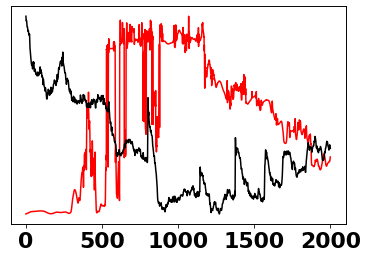

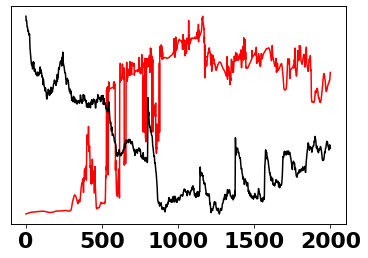

In [474]:
ts = np.sort(list(time_distances.keys()))
ds = np.asarray([time_distances[t] for t in ts])
ds_norm = np.asarray([ ds[i] / float(presz_data['Ytruth'].shape[1] - ts[i])  for i in range(len(ds))])

howmany = 2000
fig, ax = plt.subplots()
ax.plot(ts[:howmany], ds[:howmany], color='r')
ax2 = ax.twinx()
ax2.plot(presz_data['Ytruth'].mean(axis=0)[ts[:howmany]], color='k')
ax2.set_yticks([]); ax.set_yticks([])
plt.show()


fig, ax = plt.subplots()
ax.plot(ts[:howmany], ds_norm[:howmany], color='r')
ax2 = ax.twinx()
ax2.plot(presz_data['Ytruth'].mean(axis=0)[ts[:howmany]], color='k')
ax2.set_yticks([]); ax.set_yticks([])
plt.show()


# plt.figure()
# for i in range(howmany):
#     c = None
#     if ds[i] > 4: c = 'r'
#     else: c = 'b'
#     plt.scatter(*Yp_transformed[:,i], c = c)
# plt.show()


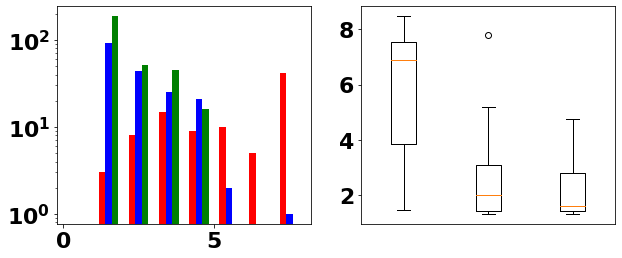

39
59
99


In [194]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(distances, rwidth=0.65, bins=np.arange(0, 9), color=['r', 'b', 'g'])
ax[0].set_yscale('log')
ax[1].boxplot(distances, positions=[0,1,2])
ax[1].set_xticks([])
plt.show()

highest_distances = np.asarray(thalamus_idxs)[np.where(np.asarray(distances[0]) > 4.0)[0]]
superhubs = [2179, 4488, 4489, 2187, 4491, 4367, 2195, 2196, 2197, 4373, 4374, 2451, 2202, 4507, 2204, 2207, 2080, 4388, 2213, 2215, 2216, 4393, 2472, 2219, 4396, 4397, 2102, 4406, 2232, 2105, 2106, 4408, 4411, 2237, 4414, 2239, 4415, 2113, 4417, 2244, 4421, 4423, 2124, 2126, 2127, 2001, 2131, 2132, 2133, 2138, 4447, 4449, 2149, 4456, 4463, 2033, 2036, 4474, 4477]
print(len(set(highest_distances) & set(superhubs) ))
print(len(superhubs))
print(len(thalamus_idxs))

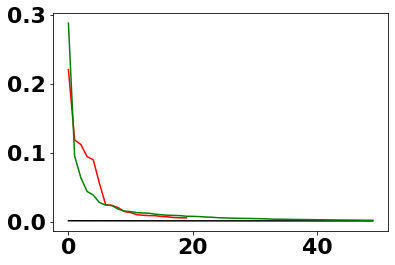

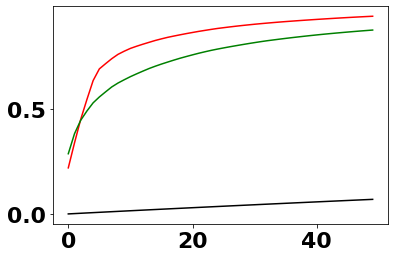

In [307]:
from scipy.signal import welch, periodogram
from futils import pca_analysis

randomf = np.load('../data/fish-perturbation/f5/edge-swap/random/fish-5-randomswap-1.npz')
randomt = randomf['traces']
randomf.close()

bifanf = np.load('../data/fish-perturbation/f5/edge-swap/bifan/fish-5-bifanswap-2.npz')
bifant = bifanf['traces']
bifanf.close()

from sklearn.decomposition import PCA

nc = 50
pca = PCA(n_components=nc)
opca = pca.fit_transform(presz_data['Ytruth'][:,::2].T).T
ovar = pca.explained_variance_ratio_

pca = PCA(n_components=nc)
bpca = pca.fit_transform(bifant.T).T
bifanvar = pca.explained_variance_ratio_

noise_traces = np.random.normal(0,1,size=bifant.shape)
pca = PCA(n_components=nc)
npca = pca.fit_transform(noise_traces.T).T
nvar = pca.explained_variance_ratio_

ovar_cumsum      = ovar.cumsum()
bifanvar_cumsum  = bifanvar.cumsum()
nvar_cumsum      = nvar.cumsum()

plt.figure()
plt.plot(var, color='r')
plt.plot(nvar, color='k')
plt.plot(ovar, color='g')
plt.show()

plt.figure()
plt.plot(bifanvar_cumsum, color='r')
plt.plot(nvar_cumsum, color='k')
plt.plot(ovar_cumsum, color='g')
plt.show()


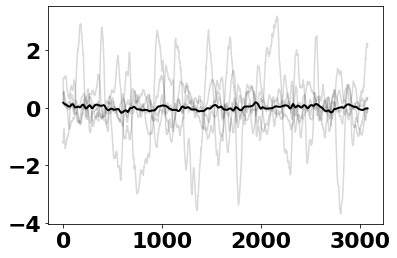

In [246]:
fig, ax = plt.subplots()
ax.plot(Y[:5,:].T, color='k', alpha=0.15)
ax.plot(Y.mean(axis=0), color='k', linewidth=2)
plt.show()

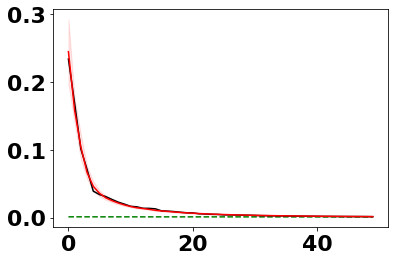

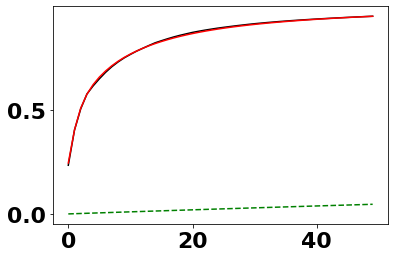

In [328]:

parameters_filepath = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f5/presz/v1/additional-info-3152020.npz'
simulation_kwargs = load_simulation_parameters(parameters_filepath)
simulation_kwargs['J'] = Jpresz
nstd = simulation_kwargs['nstd']
y0_range = simulation_kwargs['y0range']
nc = 50

# sim_vars = []
# for i in range(30):
#     simulation_kwargs['H'] = np.random.normal(0, nstd, size=presz_data['Ytruth'].shape)
#     currents    = solve_stochastic_euler(**simulation_kwargs)
#     activations = np.tanh(currents)
#     Ymodel      = np.matmul(Jpresz, activations)
    
    
#     pca = PCA(n_components=nc)
#     opca = pca.fit_transform(Ymodel.T).T
#     ovar = pca.explained_variance_ratio_
#     sim_vars.append(ovar)
#     print(i)

# sim_vars = np.asarray(sim_vars, dtype='float32')
# sim_mean, sim_std = sim_vars.mean(axis=0), sim_vars.std(axis=0)

# sim_vars2 = []
# for i in range(30):
#     simulation_kwargs['H'] = np.random.normal(0, nstd, size=presz_data['Ytruth'].shape).astype('float32')
#     simulation_kwargs['y0'] = np.random.normal(0., y0_range, size=presz_data['Ytruth'].shape[0]).astype('float32')
#     currents    = solve_stochastic_euler(**simulation_kwargs)
#     activations = np.tanh(currents)
#     Ymodel      = np.matmul(Jpresz, activations)
    
    
#     pca = PCA(n_components=nc)
#     opca = pca.fit_transform(Ymodel.T).T
#     ovar = pca.explained_variance_ratio_
#     sim_vars2.append(ovar)
#     print(i)

# sim_vars2 = np.asarray(sim_vars2, dtype='float32')
# sim_mean2, sim_std2 = sim_vars2.mean(axis=0), sim_vars2.std(axis=0)


# noise_traces = np.random.normal(0, nstd, size=presz_data['Ytruth'].shape)   
# pca = PCA(n_components=nc)
# opca = pca.fit_transform(noise_traces.T).T
# nvar = pca.explained_variance_ratio_

# pca = PCA(n_components=nc)
# opca = pca.fit_transform(presz_data['Ytruth'][:,::2].T).T
# ovar = pca.explained_variance_ratio_



plt.figure()
plt.plot(nvar, color='g', linestyle='--')
plt.plot(ovar, color='k')
plt.plot(sim_mean2, color='r')
plt.fill_between(np.arange(nc), sim_mean2 - sim_std2, sim_mean2 + sim_std2, color='r' , alpha=0.1)
plt.show()



plt.figure()
plt.plot(nvar.cumsum(), color='g', linestyle='--')
plt.plot(ovar.cumsum(), color='k')
plt.plot(sim_mean2.cumsum(), color='r')
plt.show()


